In [3]:

import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

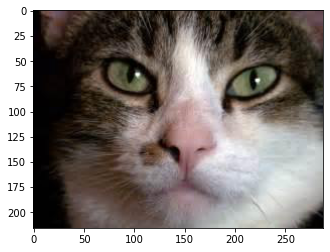

In [4]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/kaggle/input/animalsdataset/dataset/test/cat/1006.jpeg', 'r')


imshow(np.asarray(pil_im))

In [5]:

from tensorflow.keras import backend as K
from time import time

# DATA SOURCE --------------------------------------------------

train_data_dir = '/kaggle/input/animalsdataset/dataset/training'
validation_data_dir = '/kaggle/input/animalsdataset/dataset/validation'
test_data_dir = '/kaggle/input/animalsdataset/dataset/test'
image_size = (150, 150)
batch_size = 256

In [6]:
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 21068 files belonging to 10 classes.
Found 6634 files belonging to 10 classes.
Found 3418 files belonging to 10 classes.


# **Image Augmentation**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1
)

validation_datagen = ImageDataGenerator(
        rescale=1./255
)


train_ds_augmentation = train_datagen.flow_from_directory(
    train_data_dir,
    #validation_split=0.2,
    subset="training",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_ds_augmentation = validation_datagen.flow_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    subset="validation",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)



Found 21068 images belonging to 10 classes.
Found 0 images belonging to 10 classes.



# **The Model**

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential  # Importar Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout  # Importar las capas necesarias

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Congela las capas del modelo base
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [13]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [14]:
# TRAINING --------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15, restore_best_weights=True)

history = model.fit(
          train_ds,
          epochs=epochs,
          validation_data = validation_ds,
          callbacks = [es]
)

Epoch 1/10
83/83 [==============================] - 79s 693ms/step - loss: 2.9325 - accuracy: 0.5230 - val_loss: 0.9131 - val_accuracy: 0.7107
Epoch 2/10
83/83 [==============================] - 29s 333ms/step - loss: 1.1106 - accuracy: 0.6457 - val_loss: 0.7023 - val_accuracy: 0.7778
Epoch 3/10
83/83 [==============================] - 30s 338ms/step - loss: 0.9247 - accuracy: 0.7051 - val_loss: 0.6074 - val_accuracy: 0.8141
Epoch 4/10
83/83 [==============================] - 29s 331ms/step - loss: 0.8434 - accuracy: 0.7333 - val_loss: 0.5671 - val_accuracy: 0.8307
Epoch 5/10
83/83 [==============================] - 29s 334ms/step - loss: 0.7437 - accuracy: 0.7552 - val_loss: 0.5130 - val_accuracy: 0.8589
Epoch 6/10
83/83 [==============================] - 29s 333ms/step - loss: 0.6938 - accuracy: 0.7704 - val_loss: 0.5049 - val_accuracy: 0.8696
Epoch 7/10
83/83 [==============================] - 30s 337ms/step - loss: 0.6301 - accuracy: 0.7904 - val_loss: 0.4631 - val_accuracy: 0.8722

In [15]:
# SAVING --------------------------------------------------

model.save("mimodelo.h5")

#  **Evaluación de resultados**

              precision    recall  f1-score   support

           0     0.9608    0.9595    0.9602       766
           1     0.9542    0.7646    0.8489       599
           2     0.9713    0.9391    0.9549      1117
           3     0.8647    0.8621    0.8634       667
           4     0.7688    0.9342    0.8435       972
           5     0.9225    0.8235    0.8702       289
           6     0.8923    0.8225    0.8560       524
           7     0.7454    0.7720    0.7584       364
           8     0.9575    0.9585    0.9580       964
           9     0.8421    0.8602    0.8511       372

    accuracy                         0.8922      6634
   macro avg     0.8880    0.8696    0.8765      6634
weighted avg     0.8981    0.8922    0.8928      6634



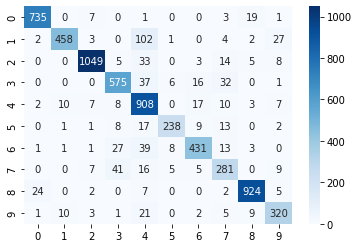

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))

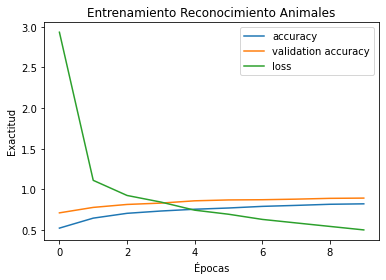

In [17]:
from matplotlib import pyplot as plt 

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento Reconocimiento Animales')

plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")

plt.show()

(150, 150, 3)
El vector de salida obtenido:  [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
La etiqueta de salida predicha es  1
Ahora dicho con texto: La etiqueta de salida predicha es  cat


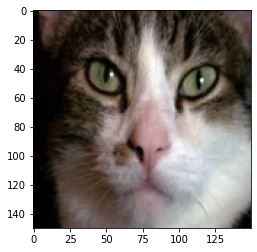

In [18]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
%matplotlib inline

pil_im = Image.open('/kaggle/input/animalsdataset/dataset/test/cat/1006.jpeg', 'r')
im = np.asarray(pil_im.resize((150, 150)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 150x150x3

# El método `predict` hace la predicción de un lote de entradas, no solo una. 
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más 
# al array numpy para que la entrada tenga la dimensión: 1x150x150x3

im = im.reshape(1,150,150,3)


print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])






In [19]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
#model.save_model("mimodelo.h5")


# LOADING --------------------------------------------------
#model = tensorflow.keras.models.load_model("mimodelo.h5")

etiquetas=['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")
try:
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"Perdida del modelo en el conjunto de prueba: {test_loss:.2f}")  # Sin multiplicar
    print(f"Precisión del modelo en el conjunto de prueba: {test_acc * 100:.2f}%")  # Multiplicado por 100
except Exception as e:
    print("Ocurrió un error durante la evaluación:", e)

ETIQUETA PREDICHA -> ETIQUETA REAL
dog -> dog
dog -> dog
spider -> spider
butterfly -> butterfly
dog -> dog
butterfly -> butterfly
chicken -> chicken
elephant -> elephant
cat -> cat
spider -> spider
dog -> dog
spider -> spider
dog -> dog
cow -> sheep ✘
dog -> dog
cow -> cow
horse -> horse
cow -> cow
cow -> cow
butterfly -> butterfly
dog -> chicken ✘
horse -> horse
cow -> cow
cat -> cat
chicken -> chicken
dog -> dog
horse -> horse
sheep -> squirrel ✘
dog -> dog
dog -> sheep ✘
elephant -> elephant
chicken -> chicken
spider -> spider
chicken -> chicken
chicken -> chicken
horse -> horse
chicken -> chicken
horse -> horse
chicken -> chicken
dog -> dog
chicken -> chicken
horse -> horse
chicken -> chicken
cow -> cow
cow -> cow
butterfly -> butterfly
chicken -> chicken
spider -> spider
chicken -> chicken
chicken -> chicken
squirrel -> squirrel
spider -> spider
dog -> dog
cow -> cow
chicken -> chicken
horse -> dog ✘
dog -> cat ✘
butterfly -> butterfly
dog -> dog
squirrel -> squirrel
spider -> sp